In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertModel, DistilBertTokenizerFast
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Grammar_autocorrection_df1_new.csv')

# DistilBERT

In [ ]:
# # ── 0) Configuration ────────────────────────────────────────────────────────
# MODEL_DIR = 'distilbert_saved_model'

# # ── 1) If already saved, just reload ────────────────────────────────────────
# if os.path.isdir(MODEL_DIR):
#     tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_DIR)
#     model     = DistilBertForSequenceClassification.from_pretrained(MODEL_DIR)
#     print(f"Loaded existing model from '{MODEL_DIR}', skipping training.")

# # ── 2) Otherwise: 5-fold CV with metrics + retrain full head ────────────────
# else:
#     # Prepare texts & labels
#     texts  = df['Ungrammatical Statement'].tolist() + df['Standard English'].tolist()
#     labels = [0]*len(df) + [1]*len(df)

#     # Initialize tokenizer & pre-tokenize
#     tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
#     encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

#     # Build Hugging Face Dataset
#     dataset = Dataset.from_dict({
#         'input_ids':      encodings['input_ids'],
#         'attention_mask': encodings['attention_mask'],
#         'labels':         labels
#     })

#     # Load model & freeze encoder layers
#     model = DistilBertForSequenceClassification.from_pretrained(
#         'distilbert-base-uncased',
#         num_labels=2
#     )
#     for param in model.distilbert.parameters():
#         param.requires_grad = False

#     # Data collator for dynamic padding
#     data_collator = DataCollatorWithPadding(tokenizer)

#     # Metric computation function
#     def compute_metrics(p):
#         preds = p.predictions.argmax(-1)
#         acc   = accuracy_score(p.label_ids, preds)
#         prec, rec, f1, _ = precision_recall_fscore_support(
#             p.label_ids, preds, average='binary'
#         )
#         return {
#             'accuracy':  acc,
#             'precision': prec,
#             'recall':    rec,
#             'f1':        f1
#         }

#     # Prepare lists to collect per-fold metrics
#     accuracy_scores  = []
#     precision_scores = []
#     recall_scores    = []
#     f1_scores        = []

#     # 5-fold CV, 1 epoch per fold for speed
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     for fold, (train_idx, val_idx) in enumerate(cv.split(texts, labels), start=1):
#         print(f"=== Fold {fold}/5 ===")
#         train_ds = dataset.select(train_idx)
#         val_ds   = dataset.select(val_idx)

#         training_args = TrainingArguments(
#             output_dir=f'./cv_fold{fold}',
#             num_train_epochs=1,
#             per_device_train_batch_size=16,
#             per_device_eval_batch_size=32,
#             eval_strategy='epoch',
#             logging_strategy='epoch',
#             save_strategy='no',
#             fp16=True,               # set to False if no GPU
#             report_to=['none'],
#             seed=42
#         )

#         trainer = Trainer(
#             model=model,
#             args=training_args,
#             train_dataset=train_ds,
#             eval_dataset=val_ds,
#             data_collator=data_collator,
#             compute_metrics=compute_metrics
#         )

#         trainer.train()
#         metrics = trainer.evaluate()

#         # Collect metrics
#         accuracy_scores.append(metrics['eval_accuracy'])
#         precision_scores.append(metrics['eval_precision'])
#         recall_scores.append(metrics['eval_recall'])
#         f1_scores.append(metrics['eval_f1'])

#         # Print per-fold results
#         print(f"Fold {fold}: "
#               f"Acc {metrics['eval_accuracy']:.4f}, "
#               f"Prec {metrics['eval_precision']:.4f}, "
#               f"Rec {metrics['eval_recall']:.4f}, "
#               f"F1 {metrics['eval_f1']:.4f}")

#     # Summarize CV
#     def report(name, vals):
#         mean, std = np.mean(vals), np.std(vals)
#         print(f"{name}: {mean:.4f} ± {std:.4f}")

#     print("\n=== CV summary over 5 folds ===")
#     report("Accuracy",  accuracy_scores)
#     report("Precision", precision_scores)
#     report("Recall",    recall_scores)
#     report("F1-score",  f1_scores)

#     # Retrain head on full dataset
#     print("\nRetraining classifier head on the full dataset…")
#     full_args = TrainingArguments(
#         output_dir='./full_train',
#         num_train_epochs=2,
#         per_device_train_batch_size=16,
#         save_strategy='no',
#         fp16=True,
#         report_to=['none']
#     )
#     trainer_full = Trainer(
#         model=model,
#         args=full_args,
#         train_dataset=dataset,
#         data_collator=data_collator,
#         compute_metrics=compute_metrics
#     )
#     trainer_full.train()

#     # Save the fine-tuned model & tokenizer
#     model.save_pretrained(MODEL_DIR)
#     tokenizer.save_pretrained(MODEL_DIR)
#     print(f"Saved model in '{MODEL_DIR}'")


In [ ]:
# # 1) Load your saved model & tokenizer
# MODEL_DIR = 'distilbert_saved_model'
# tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_DIR)
# model     = DistilBertForSequenceClassification.from_pretrained(MODEL_DIR)
# model.eval()

# # 2) Prompt the user for input
# sentence = input("Enter a sentence to check (grammar):\n> ")

# # 3) Tokenize & forward pass
# enc = tokenizer([sentence], padding=True, truncation=True, return_tensors='pt', max_length=128)
# with torch.no_grad():
#     logits = model(**enc).logits

# # 4) Convert to probabilities & predicted label
# probs = torch.softmax(logits, dim=-1)[0]
# pred  = probs.argmax().item()
# label = "Correct" if pred == 1 else "Ungrammatical"
# score = probs[pred].item()

# # 5) Print result
# print(f"\n\"{sentence}\" → {label} (confidence: {score:.2f})")

#T5 Model


In [ ]:
# import os
# import pandas as pd
# from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
# from datasets import Dataset
# import torch
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# model_name = "t5-small"
# model_dir = "./t5-grammar-correction"

# # Load tokenizer and model
# tokenizer = T5Tokenizer.from_pretrained(model_name)

# if os.path.exists(model_dir):
#     print("Saved model found. Loading the model...")
#     model = T5ForConditionalGeneration.from_pretrained(model_dir)
# else:
#     print("No saved model found. Training model from scratch...")
#     model = T5ForConditionalGeneration.from_pretrained(model_name)

#     # Prepare input and target sequences
#     inputs = ["fix: " + text for text in df['Ungrammatical Statement']]
#     targets = df['Standard English'].tolist()

#     # Tokenize input and output
#     input_encodings = tokenizer(inputs, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
#     target_encodings = tokenizer(targets, padding="max_length", truncation=True, max_length=64, return_tensors="pt")

#     labels = target_encodings["input_ids"]
#     labels[labels == tokenizer.pad_token_id] = -100

#     dataset = Dataset.from_dict({
#         'input_ids': input_encodings['input_ids'],
#         'attention_mask': input_encodings['attention_mask'],
#         'labels': labels
#     })

#     os.environ["WANDB_DISABLED"] = "true"

#     training_args = TrainingArguments(
#         output_dir=model_dir,
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         num_train_epochs=4,
#         logging_dir="./logs",
#         save_steps=500,
#         save_total_limit=2
#     )

#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=dataset,
#         eval_dataset=dataset,
#         # tokenizer=tokenizer  # Optional to keep or remove based on warning
#     )

#     trainer.train()
#     trainer.save_model(model_dir)

# # Grammar correction function
# def correct_grammar(sentence):
#     input_text = "fix: " + sentence
#     input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=64, truncation=True)
#     output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
#     return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# # Evaluation and test code (same as before)...
# print("\nEvaluating model on the dataset...\n")

# smoothie = SmoothingFunction().method4
# total_bleu = 0
# correct_count = 0

# for ungram, ref in zip(df['Ungrammatical Statement'], df['Standard English']):
#     pred = correct_grammar(ungram).strip()
#     ref = ref.strip()

#     # BLEU score
#     ref_tokens = ref.split()
#     pred_tokens = pred.split()
#     bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
#     total_bleu += bleu

#     # Exact match accuracy (case-insensitive)
#     if pred.lower() == ref.lower():
#         correct_count += 1

# average_bleu = total_bleu / len(df)
# accuracy = correct_count / len(df)

# print(f"Average BLEU score: {average_bleu:.4f}")
# print(f"Exact Match Accuracy: {accuracy:.2%}")


# print(f"Average BLEU score: {average_bleu:.4f}")
# print(f"Exact Match Accuracy: {accuracy:.2%}")

# # --- Test on a new example sentence ---
# user_sentence = input("\nEnter a sentence to correct grammar:\n")
# corrected_sentence = correct_grammar(user_sentence)
# print("Corrected:", corrected_sentence)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch

model_name = "t5-small"
model_dir = "./t5-grammar-correction-new"
k_folds = 5
num_train_epochs = 3
max_length = 64

tokenizer = T5Tokenizer.from_pretrained(model_name)

def report(name, vals):
    mean, std = np.mean(vals), np.std(vals)
    print(f"{name}: {mean:.4f} ± {std:.4f}")

smoothie = SmoothingFunction().method4

# Load your dataframe 'df' before this point
# df must have columns: 'Ungrammatical Statement', 'Standard English'

if os.path.exists(model_dir):
    print("Saved model found. Loading the model...")
    model = T5ForConditionalGeneration.from_pretrained(model_dir)

else:
    print("No saved model found. Starting training with cross-validation...")

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    bleu_scores = []

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_num = 1

    for train_index, val_index in kf.split(df):
        print(f"\n=== Fold {fold_num} ===")
        train_df = df.iloc[train_index].reset_index(drop=True)
        val_df = df.iloc[val_index].reset_index(drop=True)

        # Prepare datasets
        train_inputs = ["fix: " + text for text in train_df['Ungrammatical Statement']]
        train_targets = train_df['Standard English'].tolist()

        val_inputs = ["fix: " + text for text in val_df['Ungrammatical Statement']]
        val_targets = val_df['Standard English'].tolist()

        # Tokenize train
        train_input_encodings = tokenizer(train_inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        train_target_encodings = tokenizer(train_targets, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        train_labels = train_target_encodings["input_ids"]
        train_labels[train_labels == tokenizer.pad_token_id] = -100

        train_dataset = Dataset.from_dict({
            'input_ids': train_input_encodings['input_ids'],
            'attention_mask': train_input_encodings['attention_mask'],
            'labels': train_labels
        })

        # Tokenize validation
        val_input_encodings = tokenizer(val_inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        val_target_encodings = tokenizer(val_targets, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        val_labels = val_target_encodings["input_ids"]
        val_labels[val_labels == tokenizer.pad_token_id] = -100

        val_dataset = Dataset.from_dict({
            'input_ids': val_input_encodings['input_ids'],
            'attention_mask': val_input_encodings['attention_mask'],
            'labels': val_labels
        })

        model = T5ForConditionalGeneration.from_pretrained(model_name)

        training_args = TrainingArguments(
            output_dir=f"./t5-cv-fold{fold_num}",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            logging_dir="./logs",
            save_steps=500,
            save_total_limit=1,
            # evaluation_strategy="epoch",
            # save_strategy="epoch",
            # load_best_model_at_end=True,
            # metric_for_best_model="eval_loss",
            # greater_is_better=False,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
        )

        trainer.train()

        # Evaluate on validation set
        model.eval()
        predictions = []
        references = []

        for sentence in val_df['Ungrammatical Statement']:
            input_text = "fix: " + sentence
            input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=max_length, truncation=True)
            with torch.no_grad():
                outputs = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
            pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
            predictions.append(pred)

        references = val_df['Standard English'].str.strip().tolist()

        # Calculate BLEU and exact match accuracy
        bleu_sum = 0
        correct_exact = 0
        for pred, ref in zip(predictions, references):
            pred_tokens = pred.split()
            ref_tokens = ref.split()
            bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
            bleu_sum += bleu
            if pred.lower() == ref.lower():
                correct_exact += 1
        bleu_score = bleu_sum / len(predictions)
        accuracy = correct_exact / len(predictions)

        # Precision, Recall, F1 micro (treat exact matches as 1, else 0)
        y_true = [1] * len(references)  # all correct labels
        y_pred = [1 if p.lower() == r.lower() else 0 for p, r in zip(predictions, references)]

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='micro'
        )

        print(f"Fold {fold_num}: BLEU={bleu_score:.4f}, Accuracy={accuracy:.4f}, "
              f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        bleu_scores.append(bleu_score)

        fold_num += 1

    print("\n=== Cross-validation summary ===")
    report("BLEU", bleu_scores)
    report("Accuracy", accuracy_scores)
    report("Precision", precision_scores)
    report("Recall", recall_scores)
    report("F1-score", f1_scores)

    # Final training on full dataset
    print("\nTraining on full dataset for final model...")
    inputs = ["fix: " + text for text in df['Ungrammatical Statement']]
    targets = df['Standard English'].tolist()

    input_encodings = tokenizer(inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    target_encodings = tokenizer(targets, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

    labels = target_encodings["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100

    full_dataset = Dataset.from_dict({
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': labels
    })

    model = T5ForConditionalGeneration.from_pretrained(model_name)
    training_args = TrainingArguments(
        output_dir=model_dir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_train_epochs,
        logging_dir="./logs",
        save_steps=500,
        save_total_limit=2,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_dataset,
        eval_dataset=full_dataset,
    )

    trainer.train()
    trainer.save_model(model_dir)

# Grammar correction function using final trained or loaded model
def correct_grammar(sentence):
    input_text = "fix: " + sentence
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=max_length, truncation=True)
    output_ids = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# User input for correction
user_sentence = input("\nEnter a sentence to correct grammar:\n")
corrected_sentence = correct_grammar(user_sentence)
print("Corrected:", corrected_sentence)


No saved model found. Starting training with cross-validation...

=== Fold 1 ===


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.633000


Fold 1: BLEU=0.6675, Accuracy=0.3540, Precision=0.3540, Recall=0.3540, F1=0.3540

=== Fold 2 ===


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.597300


Fold 2: BLEU=0.6658, Accuracy=0.3069, Precision=0.3069, Recall=0.3069, F1=0.3069

=== Fold 3 ===


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.617700


Fold 3: BLEU=0.6688, Accuracy=0.3589, Precision=0.3589, Recall=0.3589, F1=0.3589

=== Fold 4 ===


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.603100


Fold 4: BLEU=0.6783, Accuracy=0.3598, Precision=0.3598, Recall=0.3598, F1=0.3598

=== Fold 5 ===


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.587700


Fold 5: BLEU=0.6624, Accuracy=0.3499, Precision=0.3499, Recall=0.3499, F1=0.3499

=== Cross-validation summary ===
BLEU: 0.6686 ± 0.0053
Accuracy: 0.3459 ± 0.0198
Precision: 0.3459 ± 0.0198
Recall: 0.3459 ± 0.0198
F1-score: 0.3459 ± 0.0198

Training on full dataset for final model...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.611800



Enter a sentence to correct grammar:
she are running late
Corrected: she is running late


<ipython-input-28-867c1ccff244>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=df_plot, x='Metric', y='Mean', palette='viridis', errorbar=None, legend=False)


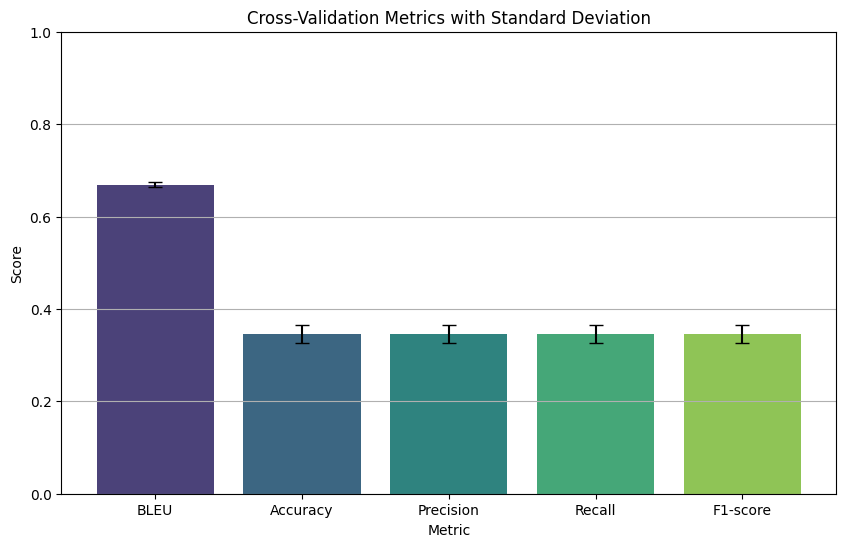

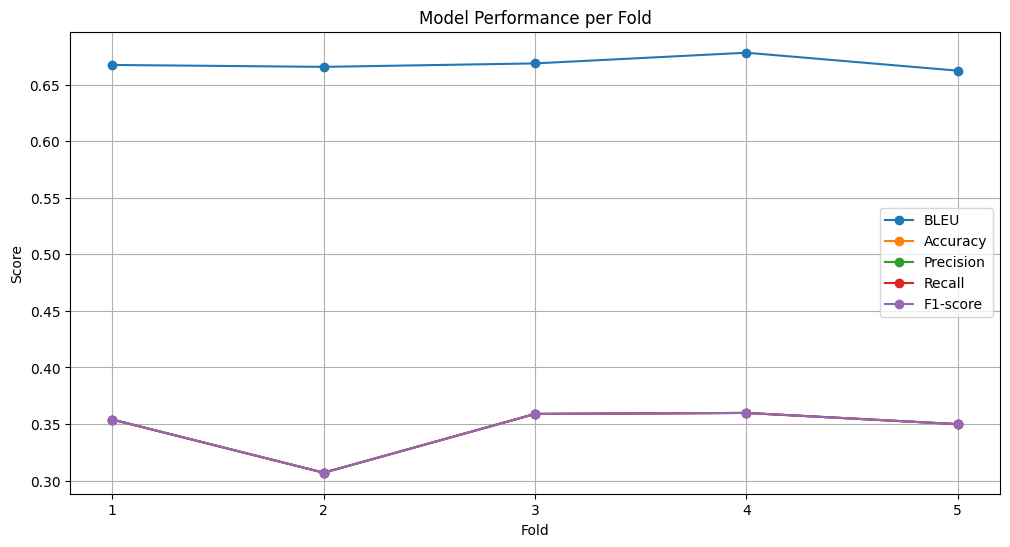

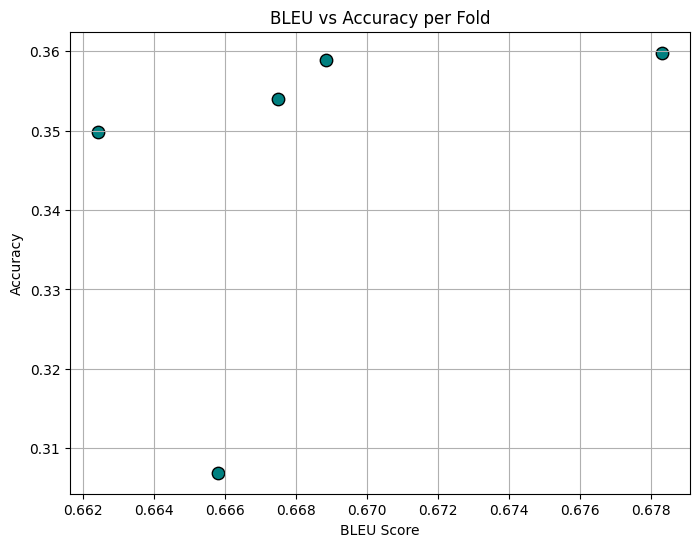

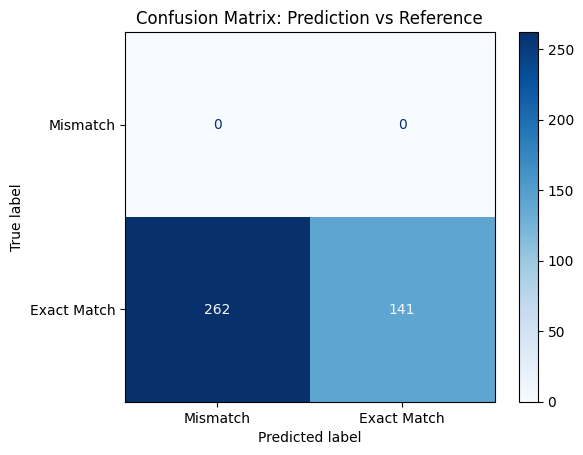

| Ungrammatical                                   | Reference                                         | Prediction                                      | Match   |
|:------------------------------------------------|:--------------------------------------------------|:------------------------------------------------|:--------|
| they was playing soccer last night              | they were playing soccer last night               | they were playing soccer last night             | True    |
| she will goes to the party tonight              | she will go to the party tonight                  | she will go to the party tonight                | True    |
| the kids plays video games after school         | the kids play video games after school            | the kids play video games after school          | True    |
| the computer not working properly               | the computer is not working properly              | the computer is not working properly            | True    |
| i has been to 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud

# === 1. Cross-Validation Metrics Summary (Bar Plot with Error Bars) ===
metrics = {
    'BLEU': bleu_scores,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
}

# Fix: Use DataFrame + matplotlib for error bars
metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]

df_plot = pd.DataFrame({
    'Metric': metric_names,
    'Mean': means,
    'Std': stds
})

plt.figure(figsize=(10, 6))
bar = sns.barplot(data=df_plot, x='Metric', y='Mean', palette='viridis', errorbar=None, legend=False)
plt.errorbar(x=range(len(means)), y=means, yerr=stds, fmt='none', c='black', capsize=5)

plt.title("Cross-Validation Metrics with Standard Deviation")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# === 2. Per-Fold Metric Trends (Line Plot) ===
folds = list(range(1, len(bleu_scores) + 1))
plt.figure(figsize=(12, 6))
for metric, values in metrics.items():
    plt.plot(folds, values, label=metric, marker='o')

plt.title("Model Performance per Fold")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()

# === 3. BLEU vs Accuracy Scatter Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(bleu_scores, accuracy_scores, c='teal', edgecolors='black', s=80)
plt.title("BLEU vs Accuracy per Fold")
plt.xlabel("BLEU Score")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# === 4. Confusion Matrix (Exact Match) ===
y_true_bin = [1] * len(y_pred)  # all correct references are labeled 1
cm = confusion_matrix(y_true_bin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mismatch", "Exact Match"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Prediction vs Reference")
plt.show()

# === 5. Sample Predictions Table (Optional print to CSV or Markdown) ===
sample_df = pd.DataFrame({
    'Ungrammatical': val_df['Ungrammatical Statement'],
    'Reference': references,
    'Prediction': predictions
})
sample_df['Match'] = sample_df['Prediction'].str.lower() == sample_df['Reference'].str.lower()

# Display a sample
print(sample_df.head(10).to_markdown(index=False))

# Optional: Export all predictions
sample_df.to_csv("sample_predictions.csv", index=False)

# === 6. Word Cloud for Error


#BART


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch

model_name = "facebook/bart-base"
model_dir = "./bart-grammar-correction"
k_folds = 5
num_train_epochs = 2
max_length = 64

tokenizer = BartTokenizer.from_pretrained(model_name)

def report(name, vals):
    mean, std = np.mean(vals), np.std(vals)
    print(f"{name}: {mean:.4f} ± {std:.4f}")

smoothie = SmoothingFunction().method4

# Assumes df is already loaded with 'Ungrammatical Statement' and 'Standard English' columns

if os.path.exists(model_dir):
    print("Saved model found. Loading the model...")
    model = BartForConditionalGeneration.from_pretrained(model_dir)

else:
    print("No saved model found. Starting training with cross-validation...")

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    bleu_scores = []

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_num = 1

    for train_index, val_index in kf.split(df):
        print(f"\n=== Fold {fold_num} ===")
        train_df = df.iloc[train_index].reset_index(drop=True)
        val_df = df.iloc[val_index].reset_index(drop=True)

        train_inputs = train_df['Ungrammatical Statement'].tolist()
        train_targets = train_df['Standard English'].tolist()

        val_inputs = val_df['Ungrammatical Statement'].tolist()
        val_targets = val_df['Standard English'].tolist()

        # Tokenize training data
        train_input_encodings = tokenizer(train_inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        train_target_encodings = tokenizer(train_targets, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        train_labels = train_target_encodings["input_ids"]
        train_labels[train_labels == tokenizer.pad_token_id] = -100

        train_dataset = Dataset.from_dict({
            'input_ids': train_input_encodings['input_ids'],
            'attention_mask': train_input_encodings['attention_mask'],
            'labels': train_labels
        })

        val_input_encodings = tokenizer(val_inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        val_target_encodings = tokenizer(val_targets, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        val_labels = val_target_encodings["input_ids"]
        val_labels[val_labels == tokenizer.pad_token_id] = -100

        val_dataset = Dataset.from_dict({
            'input_ids': val_input_encodings['input_ids'],
            'attention_mask': val_input_encodings['attention_mask'],
            'labels': val_labels
        })

        model = BartForConditionalGeneration.from_pretrained(model_name)

        training_args = TrainingArguments(
            output_dir=f"./bart-cv-fold{fold_num}",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            logging_dir="./logs",
            save_steps=500,
            save_total_limit=1,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
        )

        trainer.train()

        # Evaluate
        model.eval()
        predictions = []
        references = []

        for sentence in val_inputs:
            input_ids = tokenizer.encode(sentence, return_tensors="pt", max_length=max_length, truncation=True)
            with torch.no_grad():
                outputs = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
            pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
            predictions.append(pred)

        references = [r.strip() for r in val_targets]

        bleu_sum = 0
        correct_exact = 0
        for pred, ref in zip(predictions, references):
            pred_tokens = pred.split()
            ref_tokens = ref.split()
            bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
            bleu_sum += bleu
            if pred.lower() == ref.lower():
                correct_exact += 1
        bleu_score = bleu_sum / len(predictions)
        accuracy = correct_exact / len(predictions)

        y_true = [1] * len(references)
        y_pred = [1 if p.lower() == r.lower() else 0 for p, r in zip(predictions, references)]

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

        print(f"Fold {fold_num}: BLEU={bleu_score:.4f}, Accuracy={accuracy:.4f}, "
              f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        bleu_scores.append(bleu_score)

        fold_num += 1

    print("\n=== Cross-validation summary ===")
    report("BLEU", bleu_scores)
    report("Accuracy", accuracy_scores)
    report("Precision", precision_scores)
    report("Recall", recall_scores)
    report("F1-score", f1_scores)

    # Train final model
    print("\nTraining on full dataset for final model...")
    inputs = df['Ungrammatical Statement'].tolist()
    targets = df['Standard English'].tolist()

    input_encodings = tokenizer(inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    target_encodings = tokenizer(targets, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

    labels = target_encodings["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100

    full_dataset = Dataset.from_dict({
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': labels
    })

    model = BartForConditionalGeneration.from_pretrained(model_name)
    training_args = TrainingArguments(
        output_dir=model_dir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_train_epochs,
        logging_dir="./logs",
        save_steps=500,
        save_total_limit=2,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_dataset,
        eval_dataset=full_dataset,
    )

    trainer.train()
    trainer.save_model(model_dir)

# Grammar correction function
def correct_grammar(sentence):
    input_ids = tokenizer.encode(sentence, return_tensors="pt", max_length=max_length, truncation=True)
    output_ids = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# User interaction
user_sentence = input("\nEnter a sentence to correct grammar:\n")
corrected_sentence = correct_grammar(user_sentence)
print("Corrected:", corrected_sentence)

No saved model found. Starting training with cross-validation...

=== Fold 1 ===


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fold 1: BLEU=0.7981, Accuracy=0.5767, Precision=0.5767, Recall=0.5767, F1=0.5767

=== Fold 2 ===


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fold 2: BLEU=0.7686, Accuracy=0.5074, Precision=0.5074, Recall=0.5074, F1=0.5074

=== Fold 3 ===


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fold 3: BLEU=0.7803, Accuracy=0.5569, Precision=0.5569, Recall=0.5569, F1=0.5569

=== Fold 4 ===


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fold 4: BLEU=0.7713, Accuracy=0.5310, Precision=0.5310, Recall=0.5310, F1=0.5310

=== Fold 5 ===


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fold 5: BLEU=0.7760, Accuracy=0.5558, Precision=0.5558, Recall=0.5558, F1=0.5558

=== Cross-validation summary ===
BLEU: 0.7789 ± 0.0104
Accuracy: 0.5456 ± 0.0240
Precision: 0.5456 ± 0.0240
Recall: 0.5456 ± 0.0240
F1-score: 0.5456 ± 0.0240

Training on full dataset for final model...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mariam2206043 (mariam2206043-misr-international-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.382600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



Enter a sentence to correct grammar:
she are running late
Corrected: she is running late


<ipython-input-6-867c1ccff244>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=df_plot, x='Metric', y='Mean', palette='viridis', errorbar=None, legend=False)


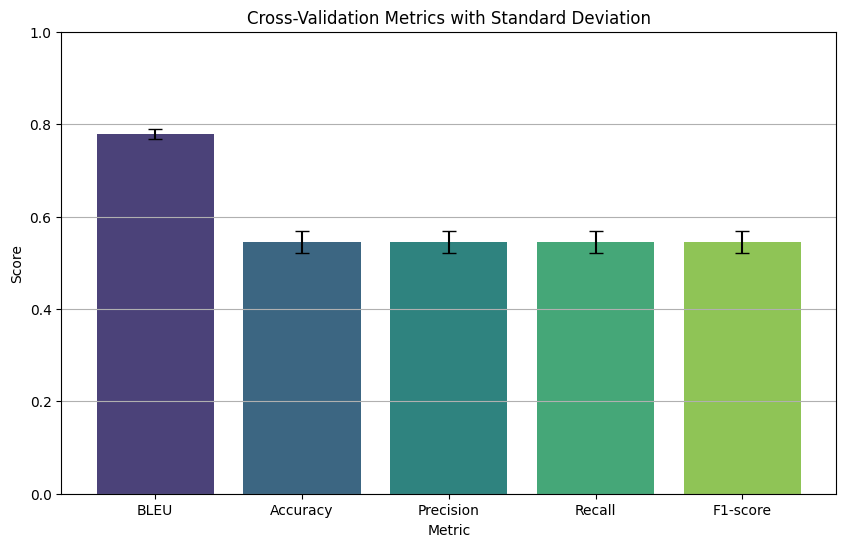

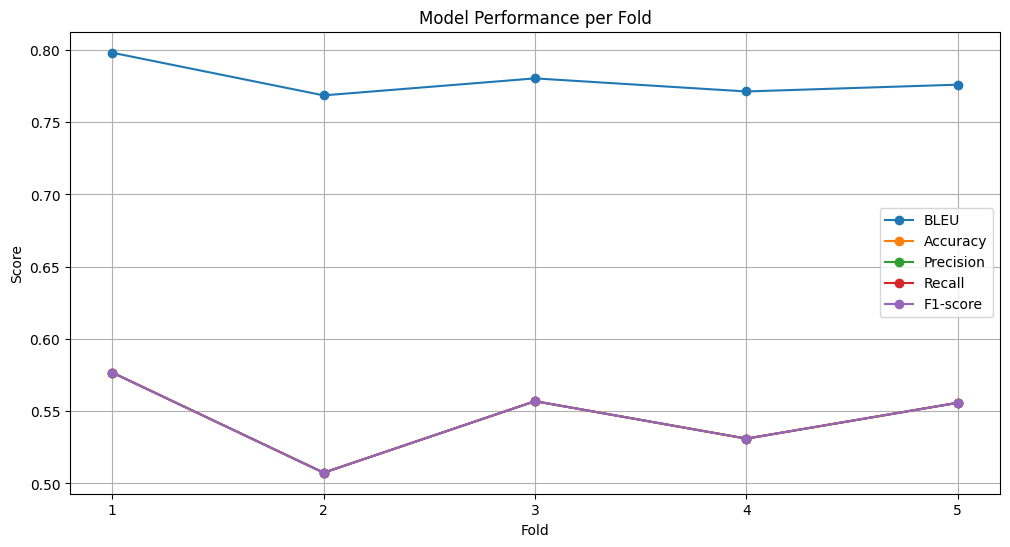

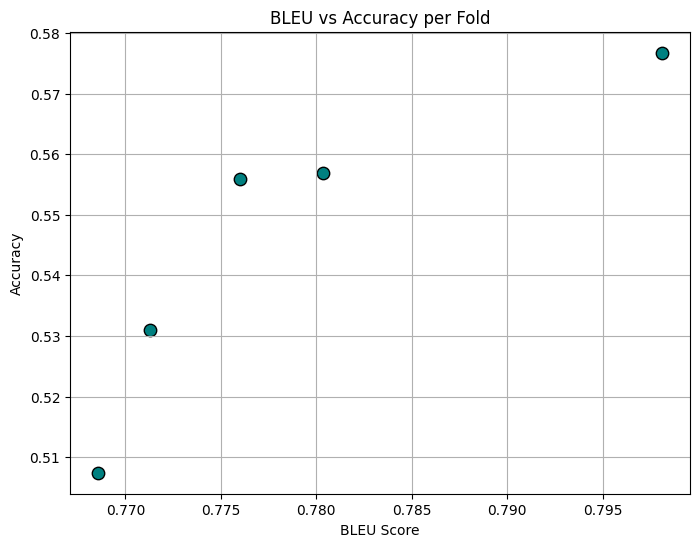

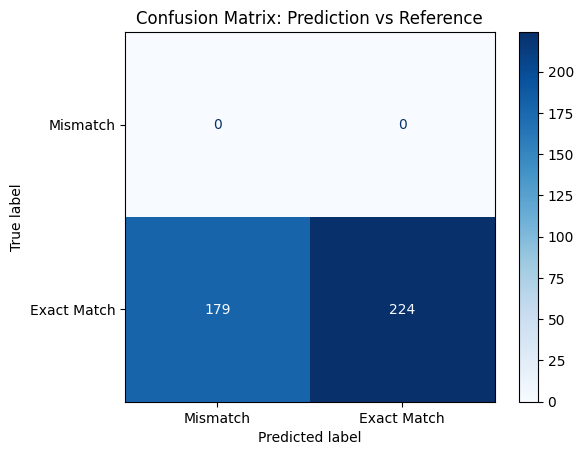

| Ungrammatical                                   | Reference                                         | Prediction                                        | Match   |
|:------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|:--------|
| they was playing soccer last night              | they were playing soccer last night               | they were playing soccer last night               | True    |
| she will goes to the party tonight              | she will go to the party tonight                  | she will go to the party tonight                  | True    |
| the kids plays video games after school         | the kids play video games after school            | the kids play video games after school            | True    |
| the computer not working properly               | the computer is not working properly              | the computer is not working properly              | True    |
| i 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud

# === 1. Cross-Validation Metrics Summary (Bar Plot with Error Bars) ===
metrics = {
    'BLEU': bleu_scores,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
}

# Fix: Use DataFrame + matplotlib for error bars
metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]

df_plot = pd.DataFrame({
    'Metric': metric_names,
    'Mean': means,
    'Std': stds
})

plt.figure(figsize=(10, 6))
bar = sns.barplot(data=df_plot, x='Metric', y='Mean', palette='viridis', errorbar=None, legend=False)
plt.errorbar(x=range(len(means)), y=means, yerr=stds, fmt='none', c='black', capsize=5)

plt.title("Cross-Validation Metrics with Standard Deviation")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# === 2. Per-Fold Metric Trends (Line Plot) ===
folds = list(range(1, len(bleu_scores) + 1))
plt.figure(figsize=(12, 6))
for metric, values in metrics.items():
    plt.plot(folds, values, label=metric, marker='o')

plt.title("Model Performance per Fold")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()

# === 3. BLEU vs Accuracy Scatter Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(bleu_scores, accuracy_scores, c='teal', edgecolors='black', s=80)
plt.title("BLEU vs Accuracy per Fold")
plt.xlabel("BLEU Score")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# === 4. Confusion Matrix (Exact Match) ===
y_true_bin = [1] * len(y_pred)  # all correct references are labeled 1
cm = confusion_matrix(y_true_bin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mismatch", "Exact Match"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Prediction vs Reference")
plt.show()

# === 5. Sample Predictions Table (Optional print to CSV or Markdown) ===
sample_df = pd.DataFrame({
    'Ungrammatical': val_df['Ungrammatical Statement'],
    'Reference': references,
    'Prediction': predictions
})
sample_df['Match'] = sample_df['Prediction'].str.lower() == sample_df['Reference'].str.lower()

# Display a sample
print(sample_df.head(10).to_markdown(index=False))

# Optional: Export all predictions
sample_df.to_csv("sample_predictions.csv", index=False)

# === 6. Word Cloud for Error
